In [31]:
# ----------------------------------------------------------------------
# Step 1: Import all necessary modules for analysis
# ----------------------------------------------------------------------
# import modules for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from aux_func import cleanUpTicks

In [3]:
# ----------------------------------------------------------------------
# Step 2: Set up db connection and session
# ----------------------------------------------------------------------
# set up sqlalchemy engine
from sqlalchemy import create_engine
engine = create_engine('sqlite:///hawaii.sqlite')

# set up sqlalchemy base
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
Base.prepare(engine, reflect=True)

# map classes
Station = Base.classes.stations
Measurement = Base.classes.measurements

# set up session
from sqlalchemy.orm import Session
session = Session(engine)

In [4]:
# ----------------------------------------------------------------------
# Step 3: Select start and end dates for my trip
# ----------------------------------------------------------------------
start_date = '2018-06-29'
end_date = '2018-07-04'

# Precipitation Analysis

In [66]:
# ----------------------------------------------------------------------
# Step 4: Plot 12 months of precipitation data using using DF.plot.
#         Since didn't have data past August 2017, set end date at the 
#         last date where data was available
# ----------------------------------------------------------------------
# create variables for last year's date in string format and query (for readability)
last_year_start = (dt.date(2017,8,23) - dt.timedelta(days=365)).isoformat()
query = f'SELECT date, precipitation FROM measurements WHERE date > "{last_year_start}"'

# read query into dataframe
last_year_prec_df = pd.read_sql(query, engine)

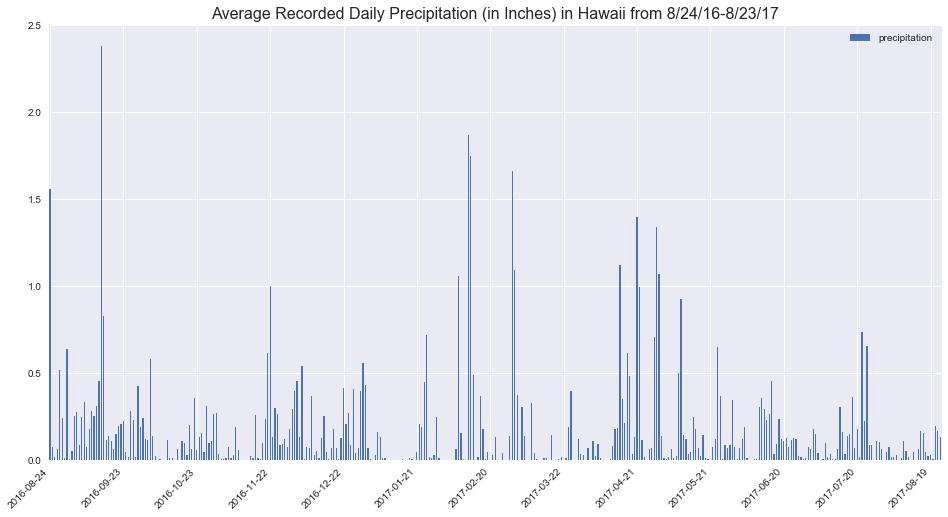

In [67]:
# set style
sns.set()
plt.rcParams["figure.figsize"] = [16,8]

# plot the dataframe
last_year_grouped_df = last_year_prec_df.groupby('date').mean().reset_index()
last_year_grouped_df.plot.bar()
plt.title('Average Recorded Daily Precipitation (in Inches) in Hawaii from 8/24/16-8/23/17', 
          size=16)

# set proper labels
plt.xticks([x*30 for x in np.arange(13)],
           [list(last_year_grouped_df['date'])[x*30] for x in np.arange(13)],
           rotation=45, horizontalalignment='right')
plt.show()

In [86]:
# display summary statistics
summary_stats_df = (last_year_prec_df.describe().reset_index().
                    rename(columns={'index':'stat'}).copy())
summary_stats_df['precipitation'] = summary_stats_df['precipitation'].round(2)
summary_stats_df

,stat,precipitation
0,count,2015.00
1,mean,0.18
2,std,0.46
3,min,0.00
4,25%,0.00
5,50%,0.02
6,75%,0.13
7,max,6.70


# Station Analysis

In [69]:
# ----------------------------------------------------------------------
# Step 5: Calculate the total number of stations
# ----------------------------------------------------------------------
total_stations = pd.read_sql('SELECT COUNT(*) AS "Total Stations" FROM stations', 
                             engine)['Total Stations'][0]
print(f"There are {total_stations} weather stations in Hawaii.")

There are 9 weather stations in Hawaii.


In [116]:
# ----------------------------------------------------------------------
# Step 6: Find the most active stations
# ----------------------------------------------------------------------
# pull the stations and observation counts in descending order
query = 'SELECT m.station, s.name, COUNT(m.temp) AS "Count Observations" \
         FROM measurements m JOIN stations s ON s.station = m.station \
         GROUP BY m.station ORDER BY COUNT(m.temp) DESC'
station_obs_count_desc = pd.read_sql(query,engine)

# display station with highest observation count and df of all stations
highest_obs = f'{station_obs_count_desc["station"][0]} {station_obs_count_desc["name"][0]}'
print(f'The station with the highest observation count is {highest_obs}.')
station_obs_count_desc

The station with the highest observation count is USC00519281 WAIHEE 837.5.


,station,name,Count Observations
0,USC00519281,WAIHEE 837.5,2772
1,USC00513117,KANEOHE 838.1,2696
2,USC00519397,WAIKIKI 717.2,2685
3,USC00519523,WAIMANALO EXPERIMENTAL FARM,2572
4,USC00516128,MANOA LYON ARBO 785.2,2484
5,USC00514830,KUALOA RANCH HEADQUARTERS 886.9,1937
6,USC00511918,HONOLULU OBSERVATORY 702.2,1932
7,USC00517948,PEARL CITY,683
8,USC00518838,UPPER WAHIAWA 874.3,342


# Temperature Analysis

In [ ]:
# ----------------------------------------------------------------------
# Step 7: Graph 12 months worth of temperature data from the station with
#       the most observations.
# ----------------------------------------------------------------------